In [1]:
import pandas as pd
import numpy as np
from io import StringIO
import re

import seaborn as sns
import matplotlib.pyplot as plt

import random
from datetime import datetime
from datetime import timedelta
import time
%matplotlib inline

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Q4. Optimizing memory is more important for longer running jobs then shorter running jobs as the resources are tied up for longer. If jobs are weighted by runtime, what is the average percent of memory used of the requested memory for each group? (i.e., what is the weighted average of memory usage vs. requested memory for each group?)

To do:  
-group data frame by user groups  
-understand sequential jobid numbering (and if that is a proxy for arrays)  
-create new columns for weighted average requested and weighted average used per group  
-focus on "production" partitions (but if there's time, look at others as well)  
-compare required time to used time and completed jobs to failed jobs; is there a buffer around run time? does the job cancel the second that used time exceeded required time?  

In [3]:
accre = pd.read_csv('../data/accre-jobs-2020-clean.csv')

In [4]:
accre.head()

,JOBID,ACCOUNT,USER,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,STATE,NODELIST,REQMEM_NO,REQMEM_TYPE,REQMEM_PER_CORE,USEDMEM_TYPE,USEDMEM_NO,USEDMEM_PER_CORE,REQTIME_DAY_SEC,REQTIME_T,REQTIME_SEC,USEDTIME_DAY_SEC,USEDTIME_T,USEDTIME_SEC
0,15925210,treviso,arabella,122880Mn,65973.49M,13-18:00:00,13-18:00:28,1,24,production,0:0,COMPLETED,cn1531,122880,Mn,5120.0,M,65973,2748.875000,1123200.0,18:00:00,1188000.0,1123200.0,18:00:28,1188028.0
1,15861126,treviso,arabella,122880Mn,67181.12M,13-18:00:00,12-14:50:56,1,24,production,0:0,COMPLETED,cn1441,122880,Mn,5120.0,M,67181,2799.208333,1123200.0,18:00:00,1188000.0,1036800.0,14:50:56,1090256.0
2,15861125,treviso,arabella,122880Mn,69111.86M,13-18:00:00,13-18:00:20,1,24,production,0:0,COMPLETED,cn1464,122880,Mn,5120.0,M,69111,2879.625000,1123200.0,18:00:00,1188000.0,1123200.0,18:00:20,1188020.0
3,16251645,treviso,arabella,122880Mn,65317.33M,13-18:00:00,12-03:50:32,1,24,production,0:0,COMPLETED,cn1473,122880,Mn,5120.0,M,65317,2721.541667,1123200.0,18:00:00,1188000.0,1036800.0,03:50:32,1050632.0
4,16251646,treviso,arabella,122880Mn,65876.11M,13-18:00:00,13-18:00:03,1,24,production,0:0,COMPLETED,cn1440,122880,Mn,5120.0,M,65876,2744.833333,1123200.0,18:00:00,1188000.0,1123200.0,18:00:03,1188003.0


In [5]:
accre.tail()

,JOBID,ACCOUNT,USER,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,STATE,NODELIST,REQMEM_NO,REQMEM_TYPE,REQMEM_PER_CORE,USEDMEM_TYPE,USEDMEM_NO,USEDMEM_PER_CORE,REQTIME_DAY_SEC,REQTIME_T,REQTIME_SEC,USEDTIME_DAY_SEC,USEDTIME_T,USEDTIME_SEC
3816285,24173815_8,portabella,vennie,32768Mn,30042.68M,1-00:00:00,00:02:27,1,2,production,0:0,COMPLETED,cn312,32768,Mn,16384.0,M,30042,15021.0,86400.0,00:00:00,86400.0,0.0,00:02:27,147.0
3816286,24173815_9,portabella,vennie,32768Mn,31067.75M,1-00:00:00,00:02:27,1,2,production,0:0,COMPLETED,cn312,32768,Mn,16384.0,M,31067,15533.5,86400.0,00:00:00,86400.0,0.0,00:02:27,147.0
3816287,24173815_10,portabella,vennie,32768Mn,21207.96M,1-00:00:00,00:01:40,1,2,production,0:0,COMPLETED,cn368,32768,Mn,16384.0,M,21207,10603.5,86400.0,00:00:00,86400.0,0.0,00:01:40,100.0
3816288,24173817,boysenberries,hortensia,100000Mn,0,1-00:00:00,00:03:05,1,8,production,0:0,RUNNING,cn1509,100000,Mn,12500.0,NaN,0,0.0,86400.0,00:00:00,86400.0,0.0,00:03:05,185.0
3816289,24173866,horseradish,ariane,20480Mn,0,05:00:00,00:02:05,1,1,production,0:0,RUNNING,cn1131,20480,Mn,20480.0,NaN,0,0.0,0.0,05:00:00,18000.0,0.0,00:02:05,125.0


Examine 'production' partitions only.

In [6]:
# accre_prod_only = accre[accre.PARTITION == 'production']
# accre_prod_only

In [7]:
# accre_prod_cplt_only = accre_prod_only[accre.STATE == 'COMPLETED']

In [8]:
#accre_mem_use = accre[(accre['EXITCODE'] == '0:0') & (accre['STATE'] == 'COMPLETED') & (accre['PARTITION'] == 'production') & (accre['USEDMEM'] != 0)]
#accre_mem_use
accre_mem_use = accre[(accre['EXITCODE'] == '0:0') & (accre['STATE'] == 'COMPLETED') & (accre['PARTITION'] == 'production') & (accre['USEDMEM_PER_CORE'] != 0)]
accre_mem_use

,JOBID,ACCOUNT,USER,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,STATE,NODELIST,REQMEM_NO,REQMEM_TYPE,REQMEM_PER_CORE,USEDMEM_TYPE,USEDMEM_NO,USEDMEM_PER_CORE,REQTIME_DAY_SEC,REQTIME_T,REQTIME_SEC,USEDTIME_DAY_SEC,USEDTIME_T,USEDTIME_SEC
0,15925210,treviso,arabella,122880Mn,65973.49M,13-18:00:00,13-18:00:28,1,24,production,0:0,COMPLETED,cn1531,122880,Mn,5120.0,M,65973,2748.875000,1123200.0,18:00:00,1188000.0,1123200.0,18:00:28,1188028.0
1,15861126,treviso,arabella,122880Mn,67181.12M,13-18:00:00,12-14:50:56,1,24,production,0:0,COMPLETED,cn1441,122880,Mn,5120.0,M,67181,2799.208333,1123200.0,18:00:00,1188000.0,1036800.0,14:50:56,1090256.0
2,15861125,treviso,arabella,122880Mn,69111.86M,13-18:00:00,13-18:00:20,1,24,production,0:0,COMPLETED,cn1464,122880,Mn,5120.0,M,69111,2879.625000,1123200.0,18:00:00,1188000.0,1123200.0,18:00:20,1188020.0
3,16251645,treviso,arabella,122880Mn,65317.33M,13-18:00:00,12-03:50:32,1,24,production,0:0,COMPLETED,cn1473,122880,Mn,5120.0,M,65317,2721.541667,1123200.0,18:00:00,1188000.0,1036800.0,03:50:32,1050632.0
4,16251646,treviso,arabella,122880Mn,65876.11M,13-18:00:00,13-18:00:03,1,24,production,0:0,COMPLETED,cn1440,122880,Mn,5120.0,M,65876,2744.833333,1123200.0,18:00:00,1188000.0,1123200.0,18:00:03,1188003.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3816283,24173815_6,portabella,vennie,32768Mn,23269.08M,1-00:00:00,00:01:36,1,2,production,0:0,COMPLETED,cn432,32768,Mn,16384.0,M,23269,11634.500000,86400.0,00:00:00,86400.0,0.0,00:01:36,96.0
3816284,24173815_7,portabella,vennie,32768Mn,20879.81M,1-00:00:00,00:01:37,1,2,production,0:0,COMPLETED,cn440,32768,Mn,16384.0,M,20879,10439.500000,86400.0,00:00:00,86400.0,0.0,00:01:37,97.0
3816285,24173815_8,portabella,vennie,32768Mn,30042.68M,1-00:00:00,00:02:27,1,2,production,0:0,COMPLETED,cn312,32768,Mn,16384.0,M,30042,15021.000000,86400.0,00:00:00,86400.0,0.0,00:02:27,147.0
3816286,24173815_9,portabella,vennie,32768Mn,31067.75M,1-00:00:00,00:02:27,1,2,production,0:0,COMPLETED,cn312,32768,Mn,16384.0,M,31067,15533.500000,86400.0,00:00:00,86400.0,0.0,00:02:27,147.0


In [9]:
# df1 = df[['a','d']]
# accre_prod_coi = accre_prod_cplt_only[['JOBID', 'ACCOUNT', 'USER', 'STATE', 'REQMEM_PER_CORE', 'USEDMEM_PER_CORE', 'REQTIME_SEC', 'USEDTIME_SEC', 'NODES', 'CPUS', 'PARTITION', 'NODELIST']]

Group DataFrame by account and then user

In [10]:
accre_q4_byacct = accre_mem_use.groupby('ACCOUNT')

In [11]:
# code to print the first entry in each of the groups
accre_q4_byacct.first()

,JOBID,USER,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,STATE,NODELIST,REQMEM_NO,REQMEM_TYPE,REQMEM_PER_CORE,USEDMEM_TYPE,USEDMEM_NO,USEDMEM_PER_CORE,REQTIME_DAY_SEC,REQTIME_T,REQTIME_SEC,USEDTIME_DAY_SEC,USEDTIME_T,USEDTIME_SEC
ACCOUNT,,,,,,,,,,,,,,,,,,,,,,,,
alkmene,17126577,velvet,8192Mn,618.83M,02:00:00,00:02:04,1,1,production,0:0,COMPLETED,cn394,8192,Mn,8192.000000,M,618,618.000000,0.0,02:00:00,7200.0,0.0,00:02:04,124.0
almonds,17655905,montie,65536Mn,104.03M,02:00:00,00:02:09,1,8,production,0:0,COMPLETED,cn496,65536,Mn,8192.000000,M,104,13.000000,0.0,02:00:00,7200.0,0.0,00:02:09,129.0
amaranth,17601641_1,alvira,8192Mn,55.55M,5-00:00:00,00:06:04,1,1,production,0:0,COMPLETED,cn1131,8192,Mn,8192.000000,M,55,55.000000,432000.0,00:00:00,432000.0,0.0,00:06:04,364.0
angelys,17420259,macey,1024Mc,192.54M,00:10:00,00:10:28,1,1,production,0:0,COMPLETED,cn394,1024,Mc,1024.000000,M,192,192.000000,0.0,00:10:00,600.0,0.0,00:10:28,628.0
anise,17117218,alvera,204800Mn,53422.29M,08:00:00,02:41:57,1,10,production,0:0,COMPLETED,cn1363,204800,Mn,20480.000000,M,53422,5342.200000,0.0,08:00:00,28800.0,0.0,02:41:57,9717.0
antares,17753831,hubbard,3072Mn,1804.89M,1-00:00:00,00:01:10,1,1,production,0:0,COMPLETED,cn1084,3072,Mn,3072.000000,M,1804,1804.000000,86400.0,00:00:00,86400.0,0.0,00:01:10,70.0
arra,17158805,needham,32768Mn,73.13M,11:00:00,00:42:26,5,2,production,0:0,COMPLETED,cn[442-446],32768,Mn,81920.000000,M,73,36.500000,0.0,11:00:00,39600.0,0.0,00:42:26,2546.0
atemoyas,17346956,pamelia,10240Mn,1379.96M,06:00:00,00:13:25,1,8,production,0:0,COMPLETED,cn1339,10240,Mn,1280.000000,M,1379,172.375000,0.0,06:00:00,21600.0,0.0,00:13:25,805.0
baby,17232606,kegan,100000Mn,5.62M,8-00:00:00,00:23:23,1,5,production,0:0,COMPLETED,cn375,100000,Mn,20000.000000,M,5,1.000000,691200.0,00:00:00,691200.0,0.0,00:23:23,1403.0


In [12]:
type(accre_q4_byacct)

pandas.core.groupby.generic.DataFrameGroupBy

In [13]:
#accre_q4_groups = accre_prod_coi.groupby(['ACCOUNT', 'USER'])
#accre_q4_groups.head()

In [14]:
accre_q4_byacct.ACCOUNT.count()

ACCOUNT
alkmene           15488
almonds            1181
amaranth           2606
angelys             205
anise               425
antares             119
arra                 59
atemoyas          22054
baby                435
baking              385
bay                 172
bell                  8
belle              5618
bertanne           4379
bibb                 92
blackberries       1233
bon                 898
boysenberries     27905
brazilnuts          678
broccoli             18
bulk              49069
bunch             88764
burro              1278
cactus              174
cantared           2304
carambola           369
carrot           179720
casaba           104022
celery            14506
cep              462929
chasselas          1309
chayote              31
chickpeas         10480
chipilin            252
cinnabar             92
clara              6305
cms              412817
cms_lowprio      105836
cmsadmin          23369
cocktail              4
concord             526
conferen

In [15]:
#accre_q4_groups.JOBID.nunique()

In [16]:
accre_mem_coi = accre_mem_use[['JOBID', 'ACCOUNT', 'USER', 'STATE', 'REQMEM_PER_CORE', 'USEDMEM_PER_CORE', 'REQTIME_SEC', 'USEDTIME_SEC', 'NODES', 'CPUS', 'PARTITION', 'NODELIST']]
accre_mem_coi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2708457 entries, 0 to 3816287
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   JOBID             object 
 1   ACCOUNT           object 
 2   USER              object 
 3   STATE             object 
 4   REQMEM_PER_CORE   float64
 5   USEDMEM_PER_CORE  float64
 6   REQTIME_SEC       float64
 7   USEDTIME_SEC      float64
 8   NODES             int64  
 9   CPUS              int64  
 10  PARTITION         object 
 11  NODELIST          object 
dtypes: float64(4), int64(2), object(6)
memory usage: 268.6+ MB


In [17]:
accre_mem_use['USEDMEM*TIMESEC'] = accre_mem_use['USEDMEM_PER_CORE']*accre_mem_use['USEDTIME_SEC']
accre_mem_use['REQMEM*TIMESEC'] = accre_mem_use['REQMEM_PER_CORE']*accre_mem_use['USEDTIME_SEC']

<ipython-input-17-d8424111ce68>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accre_mem_use['USEDMEM*TIMESEC'] = accre_mem_use['USEDMEM_PER_CORE']*accre_mem_use['USEDTIME_SEC']
<ipython-input-17-d8424111ce68>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accre_mem_use['REQMEM*TIMESEC'] = accre_mem_use['REQMEM_PER_CORE']*accre_mem_use['USEDTIME_SEC']


In [18]:
accre_mem_use.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2708457 entries, 0 to 3816287
Data columns (total 27 columns):
 #   Column            Dtype  
---  ------            -----  
 0   JOBID             object 
 1   ACCOUNT           object 
 2   USER              object 
 3   REQMEM            object 
 4   USEDMEM           object 
 5   REQTIME           object 
 6   USEDTIME          object 
 7   NODES             int64  
 8   CPUS              int64  
 9   PARTITION         object 
 10  EXITCODE          object 
 11  STATE             object 
 12  NODELIST          object 
 13  REQMEM_NO         int64  
 14  REQMEM_TYPE       object 
 15  REQMEM_PER_CORE   float64
 16  USEDMEM_TYPE      object 
 17  USEDMEM_NO        int64  
 18  USEDMEM_PER_CORE  float64
 19  REQTIME_DAY_SEC   float64
 20  REQTIME_T         object 
 21  REQTIME_SEC       float64
 22  USEDTIME_DAY_SEC  float64
 23  USEDTIME_T        object 
 24  USEDTIME_SEC      float64
 25  USEDMEM*TIMESEC   float64
 26  REQMEM*TIMESEC

In [19]:
accre_acct_user = accre_mem_use.groupby(['ACCOUNT', 'USER']).sum().reset_index()
# ['USEDMEM*TIMESEC', 'REQMEM*TIMESEC']

In [20]:
accre_acct_user

,ACCOUNT,USER,NODES,CPUS,REQMEM_NO,REQMEM_PER_CORE,USEDMEM_NO,USEDMEM_PER_CORE,REQTIME_DAY_SEC,REQTIME_SEC,USEDTIME_DAY_SEC,USEDTIME_SEC,USEDMEM*TIMESEC,REQMEM*TIMESEC
0,alkmene,abigail,19,91,372736,6.724267e+04,7367,1.203208e+03,604800.0,673200.0,86400.0,174098.0,4.445541e+07,1.362612e+09
1,alkmene,cleve,12,60,786432,1.720320e+05,9578,1.993875e+03,1900800.0,1915200.0,1900800.0,1915315.0,3.436870e+08,2.843116e+10
2,alkmene,marci,118,399,6932218,1.552719e+06,1972479,4.358358e+05,777600.0,3661200.0,0.0,839020.0,4.122353e+09,1.318533e+10
3,alkmene,vaughn,137,2286,696248,4.551794e+04,485046,2.871492e+04,0.0,10156800.0,0.0,5891190.0,1.274627e+09,1.842803e+09
4,alkmene,velvet,15247,121499,125630464,1.605094e+07,44062245,5.519795e+06,3888000.0,58786200.0,0.0,26480394.0,9.740737e+09,3.010888e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,wood,penelope,7,84,20480,1.706667e+03,7983,6.652500e+02,1382400.0,1382400.0,777600.0,978304.0,7.644648e+07,2.213825e+08
544,wood,shea,178,1424,4374528,5.468160e+05,407391,5.092388e+04,0.0,2008800.0,0.0,1064859.0,4.246257e+08,3.271247e+09
545,wood,tod,13,104,319488,3.993600e+04,35912,4.489000e+03,0.0,655200.0,0.0,45891.0,2.626501e+07,1.409772e+08
546,yu,mozelle,81,130,1389574,7.710780e+05,482473,2.604078e+05,0.0,639360.0,0.0,162089.0,6.042196e+08,1.913688e+09


In [21]:
#accre_acct_user = accre_acct_user[['ACCOUNT', 'USER', 'USEDMEM*TIMESEC', 'REQMEM*TIMESEC', 'USEDTIME_SEC']]

In [22]:
accre_acct_user['%USAGE'] = accre_acct_user['USEDMEM*TIMESEC']/accre_acct_user['REQMEM*TIMESEC'] * 100

In [23]:
accre_acct_user

,ACCOUNT,USER,NODES,CPUS,REQMEM_NO,REQMEM_PER_CORE,USEDMEM_NO,USEDMEM_PER_CORE,REQTIME_DAY_SEC,REQTIME_SEC,USEDTIME_DAY_SEC,USEDTIME_SEC,USEDMEM*TIMESEC,REQMEM*TIMESEC,%USAGE
0,alkmene,abigail,19,91,372736,6.724267e+04,7367,1.203208e+03,604800.0,673200.0,86400.0,174098.0,4.445541e+07,1.362612e+09,3.262513
1,alkmene,cleve,12,60,786432,1.720320e+05,9578,1.993875e+03,1900800.0,1915200.0,1900800.0,1915315.0,3.436870e+08,2.843116e+10,1.208839
2,alkmene,marci,118,399,6932218,1.552719e+06,1972479,4.358358e+05,777600.0,3661200.0,0.0,839020.0,4.122353e+09,1.318533e+10,31.264700
3,alkmene,vaughn,137,2286,696248,4.551794e+04,485046,2.871492e+04,0.0,10156800.0,0.0,5891190.0,1.274627e+09,1.842803e+09,69.167823
4,alkmene,velvet,15247,121499,125630464,1.605094e+07,44062245,5.519795e+06,3888000.0,58786200.0,0.0,26480394.0,9.740737e+09,3.010888e+10,32.351711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,wood,penelope,7,84,20480,1.706667e+03,7983,6.652500e+02,1382400.0,1382400.0,777600.0,978304.0,7.644648e+07,2.213825e+08,34.531405
544,wood,shea,178,1424,4374528,5.468160e+05,407391,5.092388e+04,0.0,2008800.0,0.0,1064859.0,4.246257e+08,3.271247e+09,12.980546
545,wood,tod,13,104,319488,3.993600e+04,35912,4.489000e+03,0.0,655200.0,0.0,45891.0,2.626501e+07,1.409772e+08,18.630686
546,yu,mozelle,81,130,1389574,7.710780e+05,482473,2.604078e+05,0.0,639360.0,0.0,162089.0,6.042196e+08,1.913688e+09,31.573561


In [24]:
accre_acct_user.sort_values(['%USAGE'], ascending=True)

,ACCOUNT,USER,NODES,CPUS,REQMEM_NO,REQMEM_PER_CORE,USEDMEM_NO,USEDMEM_PER_CORE,REQTIME_DAY_SEC,REQTIME_SEC,USEDTIME_DAY_SEC,USEDTIME_SEC,USEDMEM*TIMESEC,REQMEM*TIMESEC,%USAGE
95,blackberries,parker,1,24,65536,2.730667e+03,6,2.500000e-01,172800.0,172800.0,0.0,451.0,1.127500e+02,1.231531e+06,0.009155
452,sharlin,orah,438,585,11501568,8.701659e+06,1399,1.356786e+03,14860800.0,32940000.0,518400.0,3506709.0,1.430516e+07,6.929455e+10,0.020644
44,bibb,parrish,4,4,40960,4.096000e+04,146,1.460000e+02,86400.0,136800.0,0.0,26797.0,7.025800e+04,3.242803e+08,0.021666
149,cantared,merwin,89,89,712000,7.120000e+05,191,1.910000e+02,76896000.0,76896000.0,10022400.0,13371134.0,2.899532e+07,1.069691e+11,0.027106
270,galangal,belia,1,16,126976,7.936000e+03,44,2.750000e+00,86400.0,86400.0,86400.0,86409.0,2.376248e+05,6.857418e+08,0.034652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,portabella,abril,1,1,1024,1.024000e+03,1022,1.022000e+03,0.0,3600.0,0.0,3621.0,3.700662e+06,3.707904e+06,99.804688
464,st,demarcus,3,3,12288,1.228800e+04,12229,1.222900e+04,1900800.0,2001600.0,172800.0,309547.0,1.266831e+09,1.267905e+09,99.915309
246,crowns,tena,886,11,56320,5.632000e+04,101348,1.013480e+05,1296000.0,1368000.0,259200.0,681707.0,9.624251e+09,3.490340e+09,275.739660
247,crowns,wilhelmina,200,2,10240,1.024000e+04,29094,2.909400e+04,432000.0,432000.0,0.0,180.0,2.966292e+06,9.216000e+05,321.863281


In [34]:
accre_acct_user_low10 = accre_acct_user.sort_values(['%USAGE'], ascending=True).head(10)
accre_acct_user_low10

,ACCOUNT,USER,NODES,CPUS,REQMEM_NO,REQMEM_PER_CORE,USEDMEM_NO,USEDMEM_PER_CORE,REQTIME_DAY_SEC,REQTIME_SEC,USEDTIME_DAY_SEC,USEDTIME_SEC,USEDMEM*TIMESEC,REQMEM*TIMESEC,%USAGE
95,blackberries,parker,1,24,65536,2.730667e+03,6,0.250000,172800.0,172800.0,0.0,451.0,1.127500e+02,1.231531e+06,0.009155
452,sharlin,orah,438,585,11501568,8.701659e+06,1399,1356.785714,14860800.0,32940000.0,518400.0,3506709.0,1.430516e+07,6.929455e+10,0.020644
44,bibb,parrish,4,4,40960,4.096000e+04,146,146.000000,86400.0,136800.0,0.0,26797.0,7.025800e+04,3.242803e+08,0.021666
149,cantared,merwin,89,89,712000,7.120000e+05,191,191.000000,76896000.0,76896000.0,10022400.0,13371134.0,2.899532e+07,1.069691e+11,0.027106
270,galangal,belia,1,16,126976,7.936000e+03,44,2.750000,86400.0,86400.0,86400.0,86409.0,2.376248e+05,6.857418e+08,0.034652
374,pasilla,booker,330,3872,7106560,5.788160e+05,5920,372.750000,30931200.0,31912500.0,3974400.0,5838241.0,1.342093e+07,3.045818e+10,0.044063
27,bay,annabel,82,162,2023424,1.040384e+06,30506,4075.375000,1814400.0,3412800.0,1123200.0,2343556.0,1.294213e+07,2.915197e+10,0.044395
233,cocktail,rollo,4,4,40960,4.096000e+04,223,223.000000,2419200.0,2419200.0,0.0,138504.0,1.024250e+06,1.418281e+09,0.072218
375,pasilla,davon,3,3,15360,1.536000e+04,11,11.000000,518400.0,518400.0,172800.0,198768.0,7.894230e+05,1.017692e+09,0.077570
145,cantared,harm,17,272,17408,1.740800e+04,265,16.562500,3715200.0,4046400.0,1987200.0,2262809.0,2.488509e+06,2.317116e+09,0.107397


In [32]:
accre_acct_user_top10 = accre_acct_user.sort_values(['%USAGE'], ascending=True).tail(10)
accre_acct_user_top10

,ACCOUNT,USER,NODES,CPUS,REQMEM_NO,REQMEM_PER_CORE,USEDMEM_NO,USEDMEM_PER_CORE,REQTIME_DAY_SEC,REQTIME_SEC,USEDTIME_DAY_SEC,USEDTIME_SEC,USEDMEM*TIMESEC,REQMEM*TIMESEC,%USAGE
407,regal,charlotte,20,40,655360,3.276800e+05,541450,2.707250e+05,3456000.0,3456000.0,0.0,1163240.0,1.654979e+10,1.905852e+10,86.836693
411,retailer,aleck,5838,14041,182523904,7.507644e+07,145523060,6.036975e+07,4665600.0,111952800.0,86400.0,46461498.0,5.289728e+11,6.088689e+11,86.877949
278,galia,lenwood,777,7069,14340192,4.198192e+06,9975980,3.081953e+06,134611200.0,134632800.0,12873600.0,21280204.0,4.659565e+10,5.283772e+10,88.186337
512,treviso,brandon,19,19,311296,3.112960e+05,294673,2.946730e+05,0.0,1231200.0,0.0,163848.0,2.543242e+09,2.684486e+09,94.738510
176,cep,aileen,837,837,1714176,1.714176e+06,968732,9.687320e+05,224467200.0,224467200.0,53222400.0,64173838.0,1.272369e+11,1.314280e+11,96.811117
396,portabella,abril,1,1,1024,1.024000e+03,1022,1.022000e+03,0.0,3600.0,0.0,3621.0,3.700662e+06,3.707904e+06,99.804688
464,st,demarcus,3,3,12288,1.228800e+04,12229,1.222900e+04,1900800.0,2001600.0,172800.0,309547.0,1.266831e+09,1.267905e+09,99.915309
246,crowns,tena,886,11,56320,5.632000e+04,101348,1.013480e+05,1296000.0,1368000.0,259200.0,681707.0,9.624251e+09,3.490340e+09,275.739660
247,crowns,wilhelmina,200,2,10240,1.024000e+04,29094,2.909400e+04,432000.0,432000.0,0.0,180.0,2.966292e+06,9.216000e+05,321.863281
166,casaba,whitley,272,820,4310016,4.310016e+06,622230,inf,168652800.0,169039800.0,71884800.0,79465979.0,inf,1.582414e+12,inf


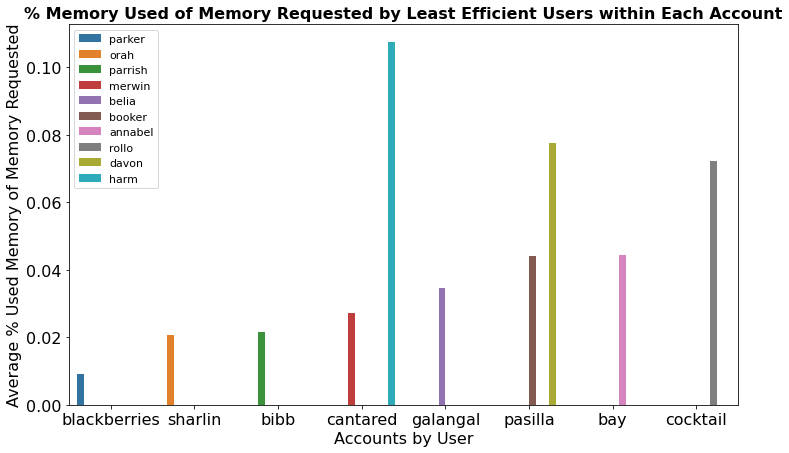

In [39]:
fontsize = 16

plt.figure(figsize = (12,7))
sns.barplot(x = 'ACCOUNT', y = '%USAGE', data = accre_acct_user_low10, hue = 'USER')

plt.xticks(fontsize = fontsize)
plt.xlabel('Accounts by User', fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.ylabel('Average % Used Memory of Memory Requested', fontsize = fontsize)
plt.title('% Memory Used of Memory Requested by Least Efficient Users within Each Account', fontsize = fontsize, fontweight = 'bold')
plt.legend(loc = 'upper left', fontsize = fontsize - 5);

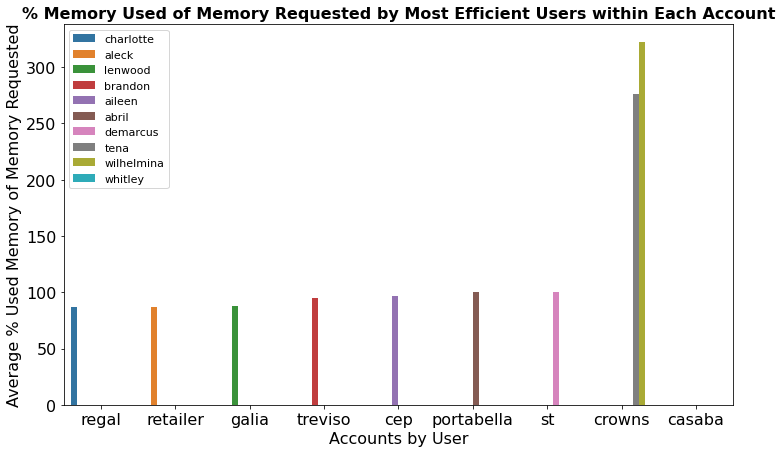

In [38]:
fontsize = 16

plt.figure(figsize = (12,7))
sns.barplot(x = 'ACCOUNT', y = '%USAGE', data = accre_acct_user_top10, hue = 'USER')

plt.xticks(fontsize = fontsize)
plt.xlabel('Accounts by User', fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.ylabel('Average % Used Memory of Memory Requested', fontsize = fontsize)
plt.title('% Memory Used of Memory Requested by Most Efficient Users within Each Account', fontsize = fontsize, fontweight = 'bold')
plt.legend(loc = 'upper left', fontsize = fontsize - 5);

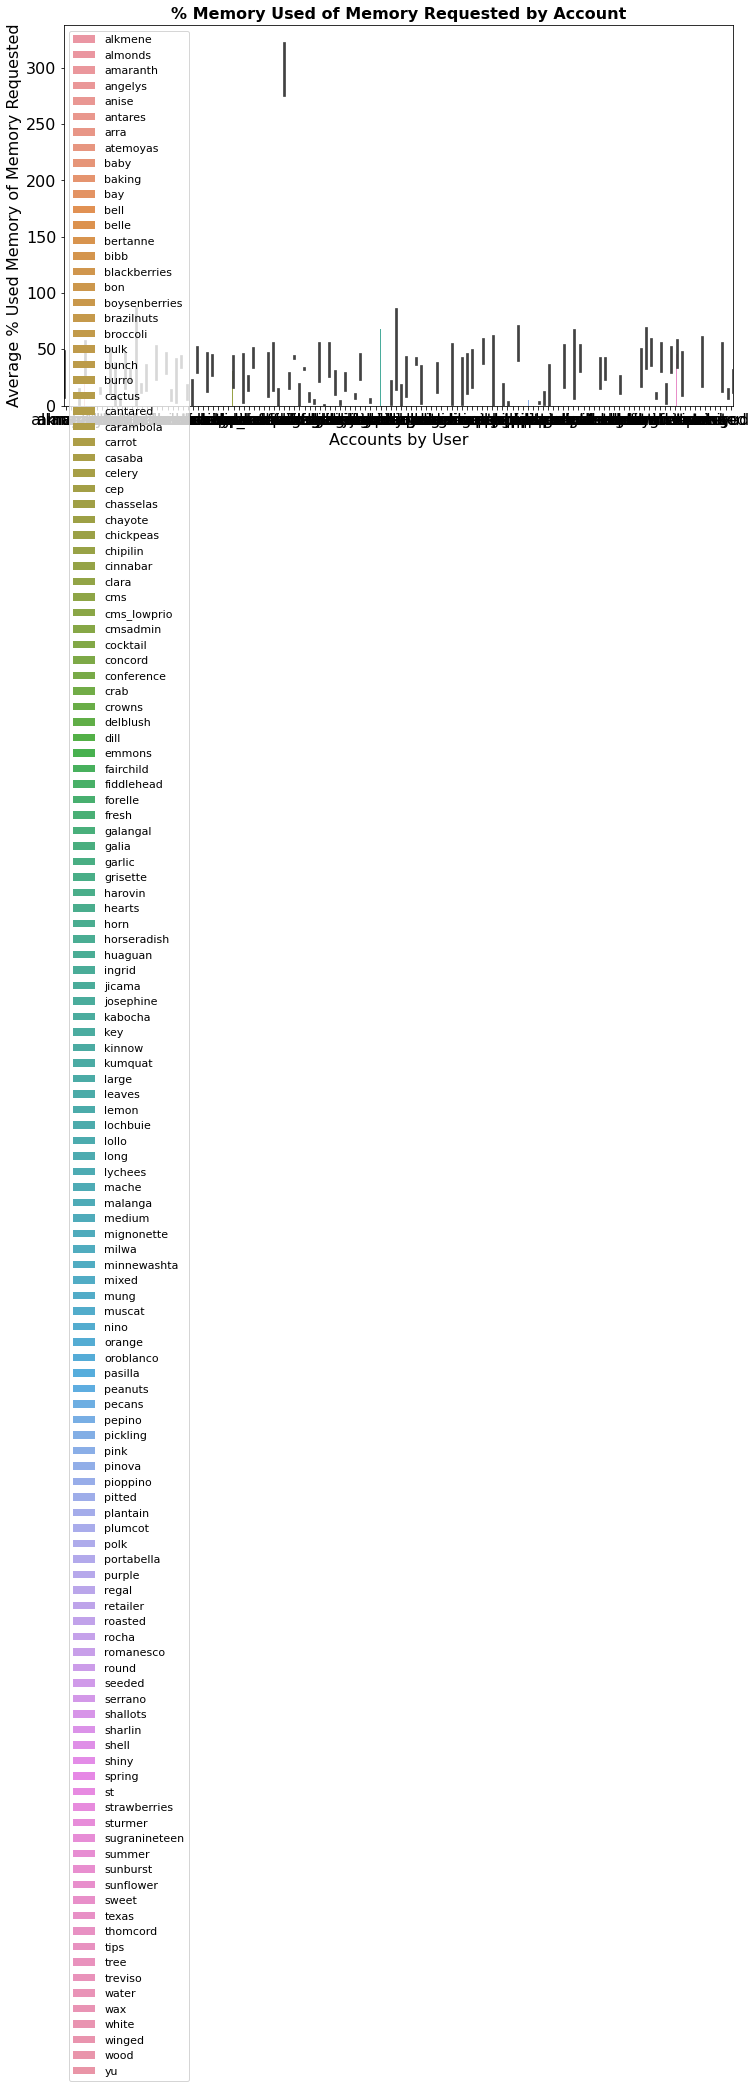

In [40]:
fontsize = 16

plt.figure(figsize = (12,7))
sns.barplot(x = 'ACCOUNT', y = '%USAGE', data = accre_acct_user, hue = 'ACCOUNT')

plt.xticks(fontsize = fontsize)
plt.xlabel('Accounts by User', fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.ylabel('Average % Used Memory of Memory Requested', fontsize = fontsize)
plt.title('% Memory Used of Memory Requested by Account', fontsize = fontsize, fontweight = 'bold')
plt.legend(loc = 'upper left', fontsize = fontsize - 5);

In [27]:
#accre_acct_avg

In [28]:
#var1 = accre_prod_coi.groupby('ACCOUNT').JOBID.nunique()
#var1

In [29]:
#accre_acct_avg['ACCT_%_AVG'] = (accre_acct_avg['USEDMEM*TIMESEC']/accre_acct_avg['REQMEM*TIMESEC']) / var1 * 100
#accre_acct_avg